In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    r2_score, mean_absolute_error, 
    mean_squared_error, explained_variance_score
)
import xgboost as xgb
import matplotlib.pyplot as plt
import pickle
import os

In [16]:
df = pd.read_csv('../data/processed/score_merge_ohe.csv')
X = df.drop(columns=['country','score'])
y = df['score']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
models = {
    'Linear': LinearRegression(),
    'Ridge':  Ridge(alpha=1.0, random_state=101),
    'Tree':   DecisionTreeRegressor(random_state=101),
    'Forest': RandomForestRegressor(n_estimators=100, random_state=101),
    'GBM':    GradientBoostingRegressor(n_estimators=100, random_state=101),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=101)
}

results = []
trained_models = {}
predictions = {}

In [19]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    trained_models[name] = model
    predictions[name] = y_pred
    results.append({
        'model': name,
        'r2': round(r2_score(y_test, y_pred), 3),
        'mae': round(mean_absolute_error(y_test, y_pred), 3),
        'rmse': round(np.sqrt(mean_squared_error(y_test, y_pred)), 3),
        'explained_var': round(explained_variance_score(y_test, y_pred), 3)
    })

In [20]:
results_df = pd.DataFrame(results).sort_values('r2', ascending=False)
print("Results:\n", results_df)

Results:
      model     r2    mae   rmse  explained_var
5  XGBoost  0.883  0.254  0.378          0.883
3   Forest  0.867  0.294  0.403          0.867
4      GBM  0.830  0.339  0.455          0.830
1    Ridge  0.782  0.390  0.515          0.783
0   Linear  0.780  0.390  0.518          0.781
2     Tree  0.777  0.322  0.521          0.780


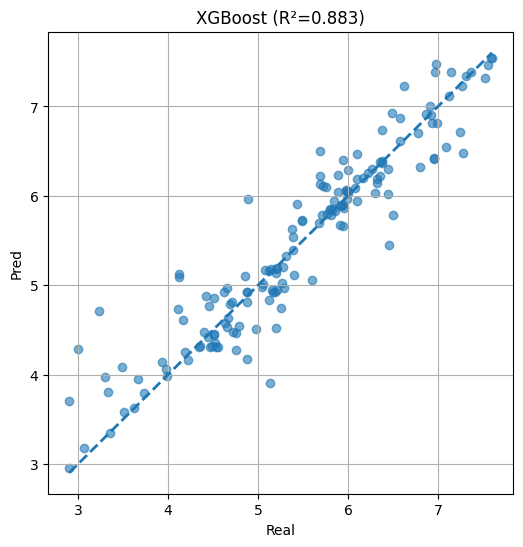

In [21]:
best_name = results_df.iloc[0]['model']
y_best = predictions[best_name]
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_best, alpha=0.6)
mn, mx = min(y_test.min(), y_best.min()), max(y_test.max(), y_best.max())
plt.plot([mn, mx], [mn, mx], '--', linewidth=2)
plt.xlabel('Real')
plt.ylabel('Pred')
plt.title(f'{best_name} (R²={results_df.iloc[0]["r2"]})')
plt.grid(True)
plt.show()

In [25]:
os.makedirs('../model', exist_ok=True)

with open('../model/GXBoost.pkl', 'wb') as f:
    pickle.dump(trained_models[best_name], f)